In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import os
import seaborn as sns

In [2]:


cur_dir = os.path.abspath('.') # Current working dir
save_name = 'result_dict.pkl'

if os.path.isfile(os.path.join(cur_dir,save_name)):
    with open(os.path.join(cur_dir,save_name),'rb') as f:
        result_dict = pickle.load(f)
else:

    # ground_truth_dataset_path = '/dev_data/zjh/LLM_CL/dataset/biography_qa/qa/all.json'
    ground_truth_dataset_path = '/dev_data/zjh/LLM_CL/dataset/biography_qa_task6/continual_data.json'
    with open(ground_truth_dataset_path,'r') as f:
        gt_dataset_all = json.load(f)

    result_dict = {}

    def compute_exact_match(pseudo_dataset, gt_dataset_input, gt_dataset_target):

        num_pseudo = len(pseudo_dataset)
        print(f'Total {num_pseudo} pseudo samples.')

        dedup_cnt = 0
        exact_match_cnt = 0
        exact_match_list = []
        exact_match_question_cnt = 0
        exact_match_question_list = []

        dedup_pseudo_dataset = list(set(pseudo_dataset))
        dedup_cnt = len(dedup_pseudo_dataset)

        dedup_ratio = dedup_cnt/num_pseudo*100
        print(f'Dedup_cnt = {dedup_cnt}, Ratio = {dedup_ratio:.2f}%.')

        for pse_i in range(len(dedup_pseudo_dataset)):
            if dedup_pseudo_dataset[pse_i][0] in gt_dataset_input:
                exact_match_question_list.append(pse_i)
                exact_match_question_cnt += 1
                gt_idx = gt_dataset_input.index(dedup_pseudo_dataset[pse_i][0])
                if dedup_pseudo_dataset[pse_i][1] == gt_dataset_target[gt_idx]:
                    exact_match_list.append(pse_i)
                    exact_match_cnt += 1

        exact_match_question_ratio = exact_match_question_cnt/num_pseudo*100
        print(f'Exact_match_question_cnt = {exact_match_question_cnt}, Ratio = {exact_match_question_ratio:.2f}%.')

        exact_match_ratio = exact_match_cnt/num_pseudo*100
        print(f'Exact_match_cnt = {exact_match_cnt}, Ratio = {exact_match_ratio:.2f}%.')

        return num_pseudo, dedup_cnt, \
                exact_match_cnt, exact_match_list, \
                exact_match_question_cnt, exact_match_question_list, 

    LAMOL_gamma = 0.20
    pseudo_dataset_dir = '/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-pretrained-100k-tmp_LAMOL_g_lambda_010/2024-09-03-15-11-52/'

    for cur_task_id in range(1,6): 

        gt_dataset_input = [] # [input1, input2,...]
        gt_dataset_target = [] # [target1, target2,...]
        pseudo_dataset = [] # [(input1, target1), (input2, target2)...]

        for pseudo_task_id in range(cur_task_id): 
            for _input in gt_dataset_all[str(pseudo_task_id)]['train']['input']:
                gt_dataset_input.append(_input)
            for _target in gt_dataset_all[str(pseudo_task_id)]['train']['target']:
                gt_dataset_target.append(_target)

            file_name = f'Pseudo_Dataset_Train_{cur_task_id}_Task_{pseudo_task_id}.pkl'
            print(f'Loading {file_name}')
            pseudo_dataset_path = os.path.join(pseudo_dataset_dir,file_name)

            with open(pseudo_dataset_path,'rb') as f:
                _pseudo_dataset = pickle.load(f)

            for pse_i in range(len(_pseudo_dataset['input'])):
                pseudo_dataset.append((_pseudo_dataset['input'][pse_i],_pseudo_dataset['target'][pse_i]))

        # valid_pseudo_ratio = num_pseudo/(num_training*LAMOL_gamma/cur_task_id)*100
        # print(f'Valid pseduo samples ratio = {valid_pseudo_ratio:.2f}% ')
        num_pseudo, dedup_cnt, exact_match_cnt, exact_match_list, \
        exact_match_question_cnt, exact_match_question_list  = \
            compute_exact_match(pseudo_dataset, gt_dataset_input, gt_dataset_target)

        if result_dict.get(cur_task_id,None) is None:
            result_dict[cur_task_id] = {}
        result_dict[cur_task_id] = {
            'num_pseudo': num_pseudo,
            'dedup_cnt' : dedup_cnt, 
            'exact_match_question_cnt': exact_match_question_cnt, 
            'exact_match_question_list': exact_match_question_list,
            'exact_match_cnt' : exact_match_cnt, 
            'exact_match_list': exact_match_list, 
        }

    with open(os.path.join(cur_dir,save_name),'wb') as f:
        pickle.dump(result_dict, f)


<Figure size 640x480 with 0 Axes>

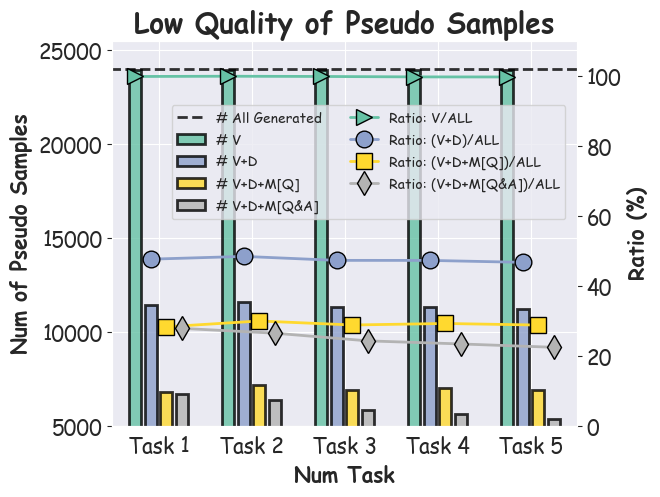

In [3]:

sns.set_theme(None)
plt.clf()
plt.rcParams['font.sans-serif'] = 'Comic Sans MS'

handle_list = []

cmap = plt.get_cmap('Set2')
num_task = 5
num_metric = 4
data_bar = np.zeros((num_task, num_metric)) # (5, 4) 

# print(result_dict)
metric_list = ['num_pseudo','dedup_cnt','exact_match_question_cnt','exact_match_cnt']
num_metric = len(metric_list)
x_offset = np.linspace(0,1,num_metric)

for t_id in range(1,num_task+1):
    for metric_id, metric_name in enumerate(metric_list):
        data_bar[t_id-1,metric_id] = result_dict[t_id][metric_name]

labels = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5']

num_labels = len(labels)
x = np.arange(num_labels)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(6,5))
ax.set_title('Low Quality of Pseudo Samples', fontsize=20, fontweight='bold')

_handle = ax.hlines(y=24000,xmin=-1,xmax=5,linestyles='--',linewidth=2,colors='black',alpha=0.8)
handle_list.append(_handle)

for i, _metric in enumerate(metric_list):
    _handle = ax.bar(x - 0.5*width + width*x_offset[i], 
        data_bar[:,i], 
        width=width/num_metric, 
        label=_metric, 
        edgecolor='black',
        linewidth=2,
        color=cmap(x_offset[i]),
        alpha=0.8
        )
    handle_list.append(_handle)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Num Task', fontsize=15, fontweight='bold')
ax.set_ylabel('Num of Pseudo Samples', fontsize=15, fontweight='bold')
ax.set_xlim((-0.5,4.5))
ax.set_ylim((5000,25500))
ax.set_xticks(ticks=x, labels=labels, fontsize=15)
ax.set_yticks(ticks=list(range(5000,25000+1,5000)), labels=list(range(5000,25000+1,5000)), fontsize=15)

ax2 = ax.twinx()
ax2.grid(False)
data_ratio = data_bar/24000*100 # %
marker_list = ['>','o','s','d']
for i, _metric in enumerate(metric_list):
    _handle, = ax2.plot(x - 0.5*width + width*x_offset[i], data_ratio[:,i], 
                        linewidth=2,
                        marker=marker_list[i], 
                        markersize=12,
                        mec='black',
                        color=cmap(x_offset[i]))
    handle_list.append(_handle)
ax2.set_ylim((0,110))
ax2.set_yticks(ticks=list(range(0,100+1,20)), labels=list(range(0,100+1,20)), fontsize=15)
ax2.set_ylabel('Ratio (%)', fontsize=15, fontweight='bold')

legend_list =   ['# All Generated'] + \
                ['# V','# V+D','# V+D+M[Q]','# V+D+M[Q&A]'] + \
                ['Ratio: V/ALL', 'Ratio: (V+D)/ALL','Ratio: (V+D+M[Q])/ALL','Ratio: (V+D+M[Q&A])/ALL']
plt.legend(handle_list,
        legend_list,
        ncol=2,
        bbox_to_anchor=(0.99,0.85))

save_dir = os.path.abspath('.')
save_name = 'lamol_cnt'
plt.savefig(os.path.join(save_dir,f'{save_name}.pdf'),dpi=1200,bbox_inches='tight',facecolor='white')
plt.savefig(os.path.join(save_dir,f'{save_name}.png'),dpi=1200,bbox_inches='tight',facecolor='white')
# print(f'Save figures to {os.path.join(save_dir)}')
plt.show()


